# Plot CORSIKA data 

## version: 2026-01-25

thinned file from `/data/sim/IceCubeUpgrade/CosmicRay/Radio/coreas/data/continuous/star-pattern`

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft, constants, optimize
from functions import *

# parameter setting

In [4]:
#=====================================
# set primary particle parameters
#=====================================

primary = "proton"
energy = "lgE_17.0"
sin2theta = "0.4"
runnum = 1

plt.rcParams["font.size"] = 14

#=====================================
# file paths 
#=====================================
# rawdata = # need to set path to simulation raw data
flong = lambda runnum: f'rawdata/{primary}/{energy}/sin2_{sin2theta}/{runnum:06d}/DAT{runnum:06d}.long'
flist = lambda runnum: f'rawdata/{primary}/{energy}/sin2_{sin2theta}/{runnum:06d}/SIM{runnum:06d}.list'
finp = lambda runnum: f'rawdata/{primary}/{energy}/sin2_{sin2theta}/{runnum:06d}/SIM{runnum:06d}.inp'
fNmu = lambda runnum: f'Particles/{primary}/{energy}/sin2_{sin2theta}/DAT{runnum:06d}_mupm.dat'
fNe = lambda runnum: f'Particles/{primary}/{energy}/sin2_{sin2theta}/DAT{runnum:06d}_epm.dat'
fNmu_tot = f'Particles/{primary}/{energy}/sin2_{sin2theta}/TOTAL_mupm.dat'
fNe_tot = f'Particles/{primary}/{energy}/sin2_{sin2theta}/TOTAL_epm.dat'

#=====================================
# load data
#=====================================

# antenna positions
xypos = lambda runnum: pd.read_csv(flist(runnum), sep=r"\s+",header=None)
ant_x = xypos(runnum)[2].astype(float)/1e2 # x position in m
ant_y = xypos(runnum)[3].astype(float)/1e2 # y position in m

# muon numbers
datamu = np.loadtxt(fNmu(runnum))
mux = datamu[:,4]/1e3
muy = datamu[:,5]/1e3
w_mu = datamu[:,7]

# electron numbers
datae = np.loadtxt(fNe(runnum))
ex = datae[:,4]/1e3
ey = datae[:,5]/1e3
w_e = datae[:,7]


# longitudinal profile 

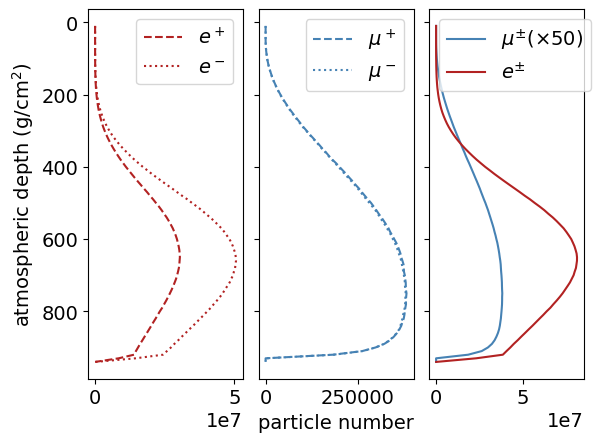

In [5]:
# load files
data = np.loadtxt(flong(runnum), skiprows=2, max_rows = 94)
atmdepth = data[:,0]

# extract data
positron = data[:,2]
electron = data[:,3]
tot_e = positron + electron

muplus = data[:,4]
muminus = data[:,5]
tot_mu = (muplus + muminus)*50

# plot
pltlp(atmdepth, positron, electron, muplus, muminus, tot_e, tot_mu)

# particle distributions

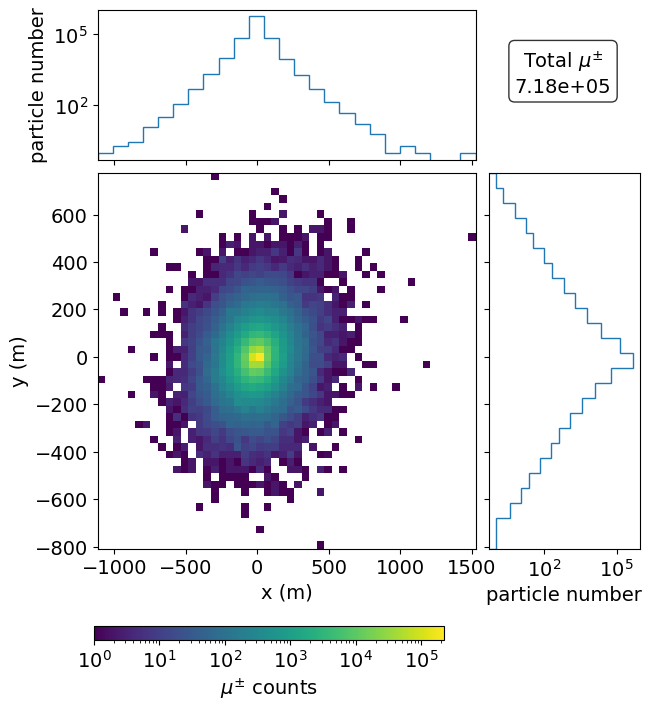

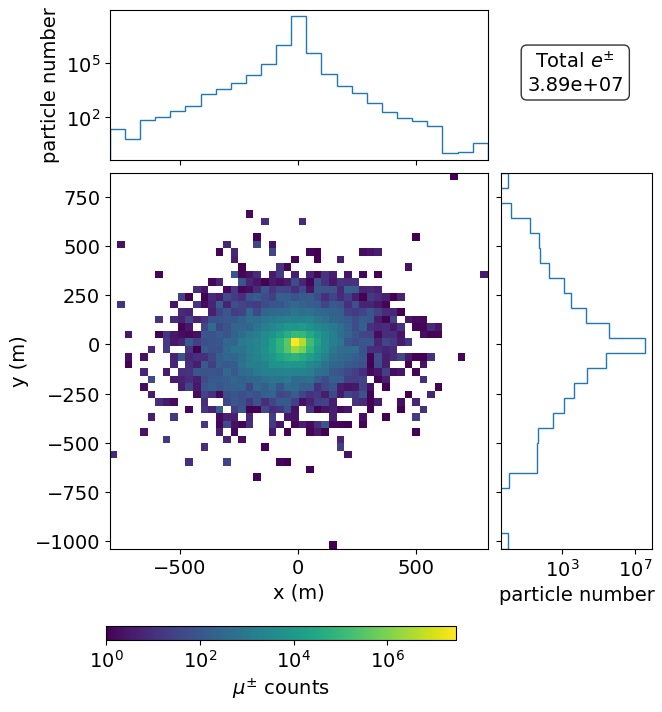

In [10]:
pltNpar(mux, muy, w_mu, 'muon')
pltNpar(ex, ey, w_e, 'electron')

# Nmu, Ne correlation

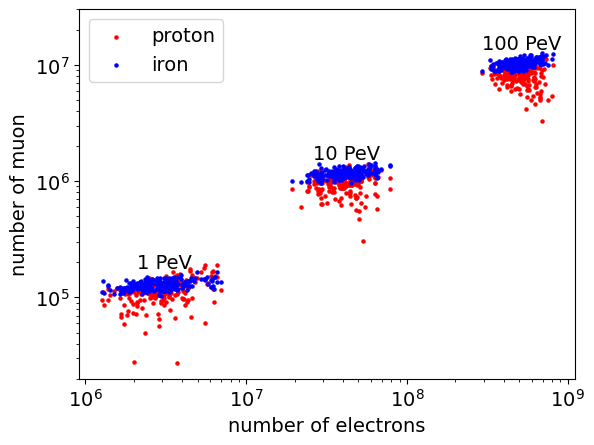

In [7]:
energies = [16.0, 17.0, 18.0] ## Energy logE 
energylabel = ["1 PeV", "10 PeV", "100 PeV"]

for i in range (len(energies)):
    energydir = f'lgE_{energies[i]}'
    
    labels = energylabel[i]
    pltmuecorr(energydir, sin2theta, labels)

# Energy radiation with bandpass filter

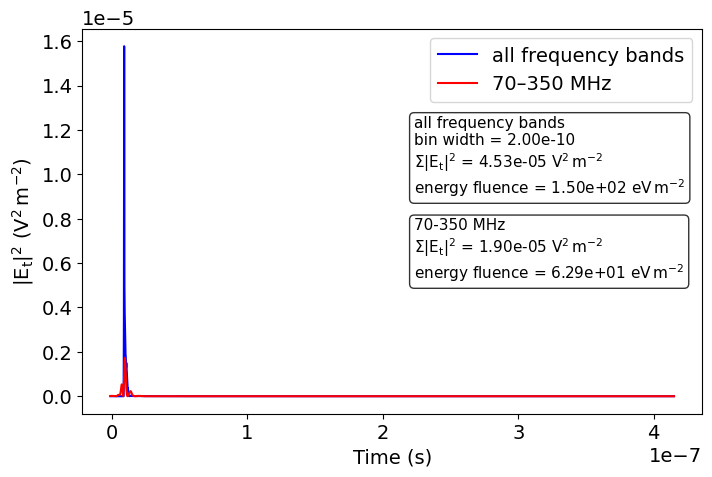

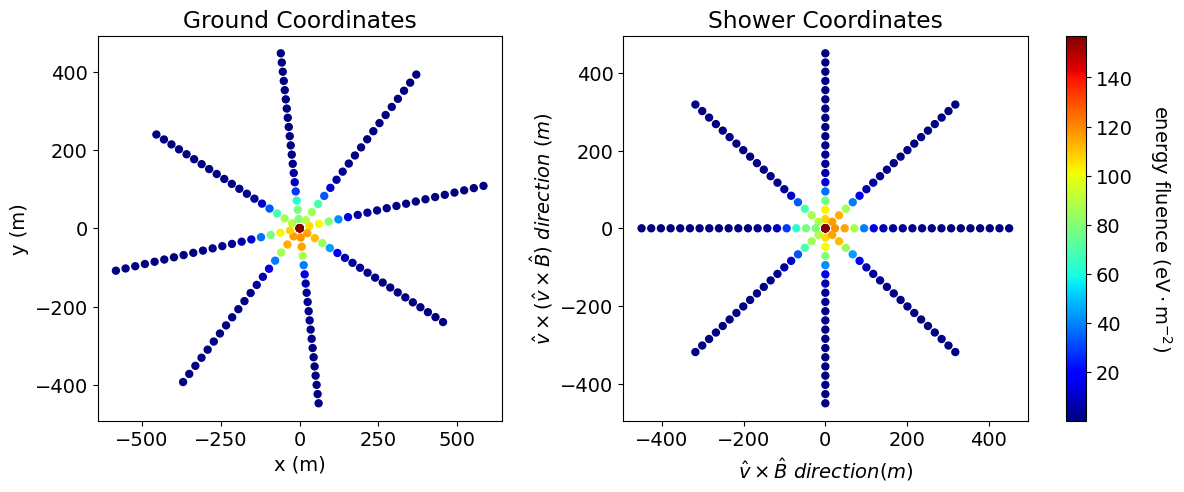

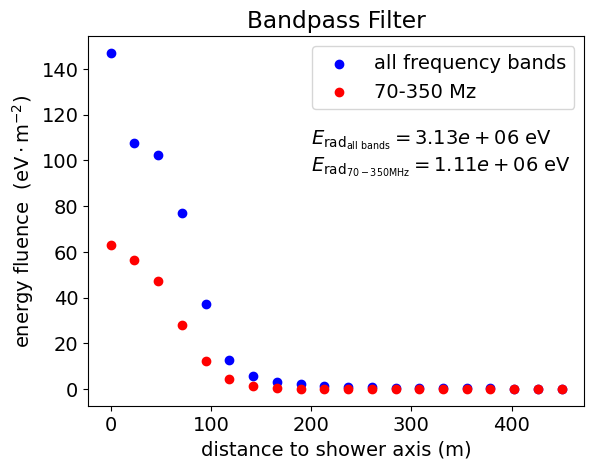

In [8]:
Nant = 160 #number of total antennas
# create empty arrays of energy fluence, filtered energy fluence, vxB, and vxvxB
ef, eff, vxB, vxvxB = (np.empty(Nant) for _ in range(4))

# 160 antenna (Nant = 160) loop
for i, ant_no in enumerate(range (1,Nant+1)):
    
    radio_dat = np.loadtxt(radiofile(primary, energy, sin2theta, runnum, ant_no))

    # extract data
    time = radio_dat[:,0]
    E_SI = 29979 # electric field converter from cgs unit to SI unit 1 statV/cm≈29,979 V/m
    Ex, Ey, Ez = radio_dat[:,1]*E_SI, radio_dat[:,2]*E_SI, radio_dat[:,3]*E_SI # north, west, vertical electric field in V/m

    #filter electric field using signal.butter
    b, a = signal.butter(5, [70e6, 350e6] , 'bp', fs=5e9)
    Ex_f, Ey_f, Ez_f = (signal.filtfilt(b, a, i) for i in (Ex, Ey, Ez))

    # |E|^2 raw and filtered
    Emag2, Emag2_f = magE2(Ex, Ey, Ez), magE2(Ex_f, Ey_f, Ez_f) 

    # sum(|E|^2)
    E_sum, E_sum_f = sum(Emag2), sum(Emag2_f)
     
    # energy fluence 
    ef[i], eff[i] = energyfluence(E_sum), energyfluence(E_sum_f)

    # plot |E|^2 histogram for antenna number 1 
    if ant_no == 1:
        pltEmag2(time, time, Emag2, Emag2_f, E_sum, E_sum_f, 'plot')

# plot energy fluence map choose weather colors = ef or colors = eff
inpfile = finp(runnum)
pltefmap(inpfile, Nant, vxB, vxvxB, ant_x, ant_y, ef)

# plot radius vs energy fluence
pltef(vxB, vxvxB, ef, eff, 'bp')

# Energy radiation with FFT

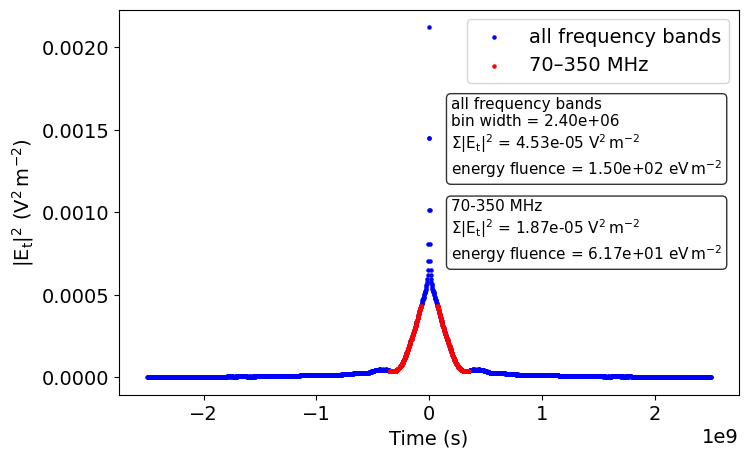

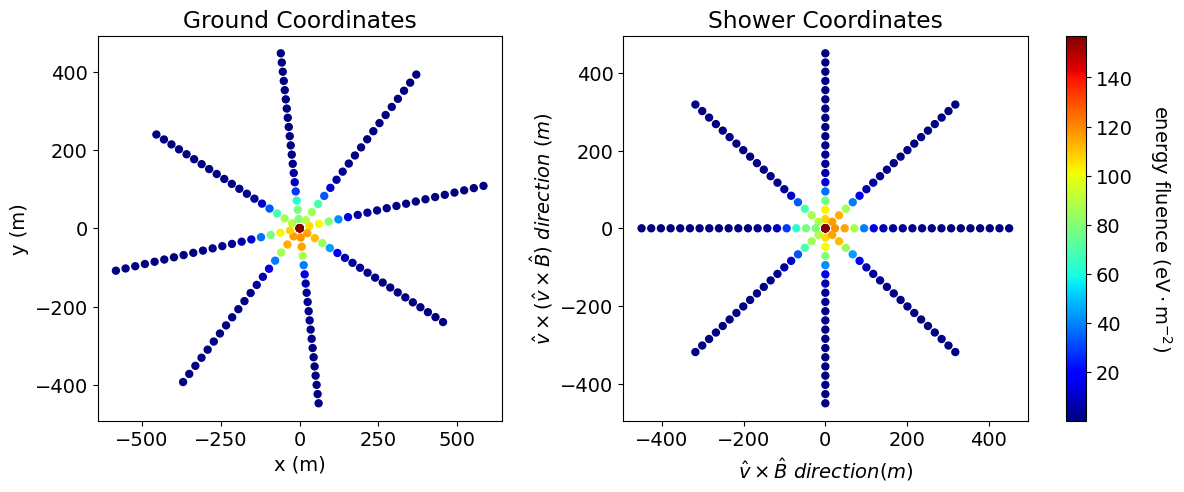

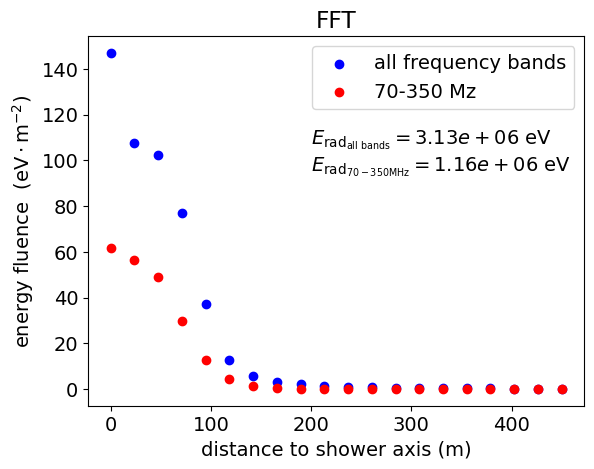

In [9]:
Nant = 160 #number of total antennas
# create empty arrays of energy fluence, filtered energy fluence, vxB, and vxvxB
ef, eff, vxB, vxvxB = (np.empty(Nant) for _ in range(4))

fmin,fmax = 70e6, 350e6 # frequency range 70-350 MHz

# 160 antenna (Nant = 160) loop
for i, ant_no in enumerate(range (1,Nant+1)):
    
    radio_dat = np.loadtxt(radiofile(primary, energy, sin2theta, runnum, ant_no))

    # extract data
    time = radio_dat[:,0]
    E_SI = 29979 # electric field converter from cgs unit to SI unit 1 statV/cm≈29,979 V/m
    Ex, Ey, Ez = radio_dat[:,1]*E_SI, radio_dat[:,2]*E_SI, radio_dat[:,3]*E_SI # north, west, vertical electric field in V/m
    Er = np.sqrt(Ex**2 + Ey**2 + Ez**2) 

    # FFT
    dt = time[1] - time[0]
    N  = len(time)
    Efft = fft.fft(Er) # real valued signal, use rfft
    freq = (np.fft.fftfreq(N, dt))

    Efft2 = abs(Efft)**2
    E_sum = fftsum(N, Efft2)

    # restrict energy range
    mask = (abs(freq) >= fmin) & (abs(freq) <= fmax)
    Efft2_mask = abs(Efft[mask])**2
    freq_f = freq[mask]
    E_sum_f = fftsum(N, Efft2_mask)

    # energy fluence 
    ef[i], eff[i] = energyfluence(E_sum), energyfluence(E_sum_f)

    # plot |E|^2 histogram for antenna number 1 
    if ant_no == 1:
        pltEmag2(freq, freq_f, Efft2, Efft2_mask, E_sum, E_sum_f, 'scatter')

# plot energy fluence map choose weather colors = ef or colors = eff
inpfile = finp(runnum)
pltefmap(inpfile, Nant, vxB, vxvxB, ant_x, ant_y, ef)

# plot radius vs energy fluence
pltef(vxB, vxvxB, ef, eff, 'fft')